In [ ]:
#Force google colab to switch to high ram mode. Run it only once. 
a = []
while(1):
    a.append('1')
#Also change runtime type to enable GPU from menu.

In [ ]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt
import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;
from tensorflow.keras.callbacks import TensorBoard;
IMAGE_SIZE = 75;

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_File = drive.CreateFile({'id': '1S2Hv1_3FDi5lBGBU-4CMzQs_pPNDBthC'});
test_Data_File = drive.CreateFile({'id': '14Ih1ZbzYasw5Sir57qKuBRmM0rvvaDxW'});

In [ ]:
#This block takes 6-10 minutes to load the training data.
train_Data_File.GetContentFile('Cat_Dog_Train_Data.npy');
train_Data = np.load('Cat_Dog_Train_Data.npy', allow_pickle=True)

In [ ]:
test_Data_File.GetContentFile('Cat_Dog_Test_Data.npy');
test_Data = np.load('Cat_Dog_Test_Data.npy', allow_pickle= True)

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

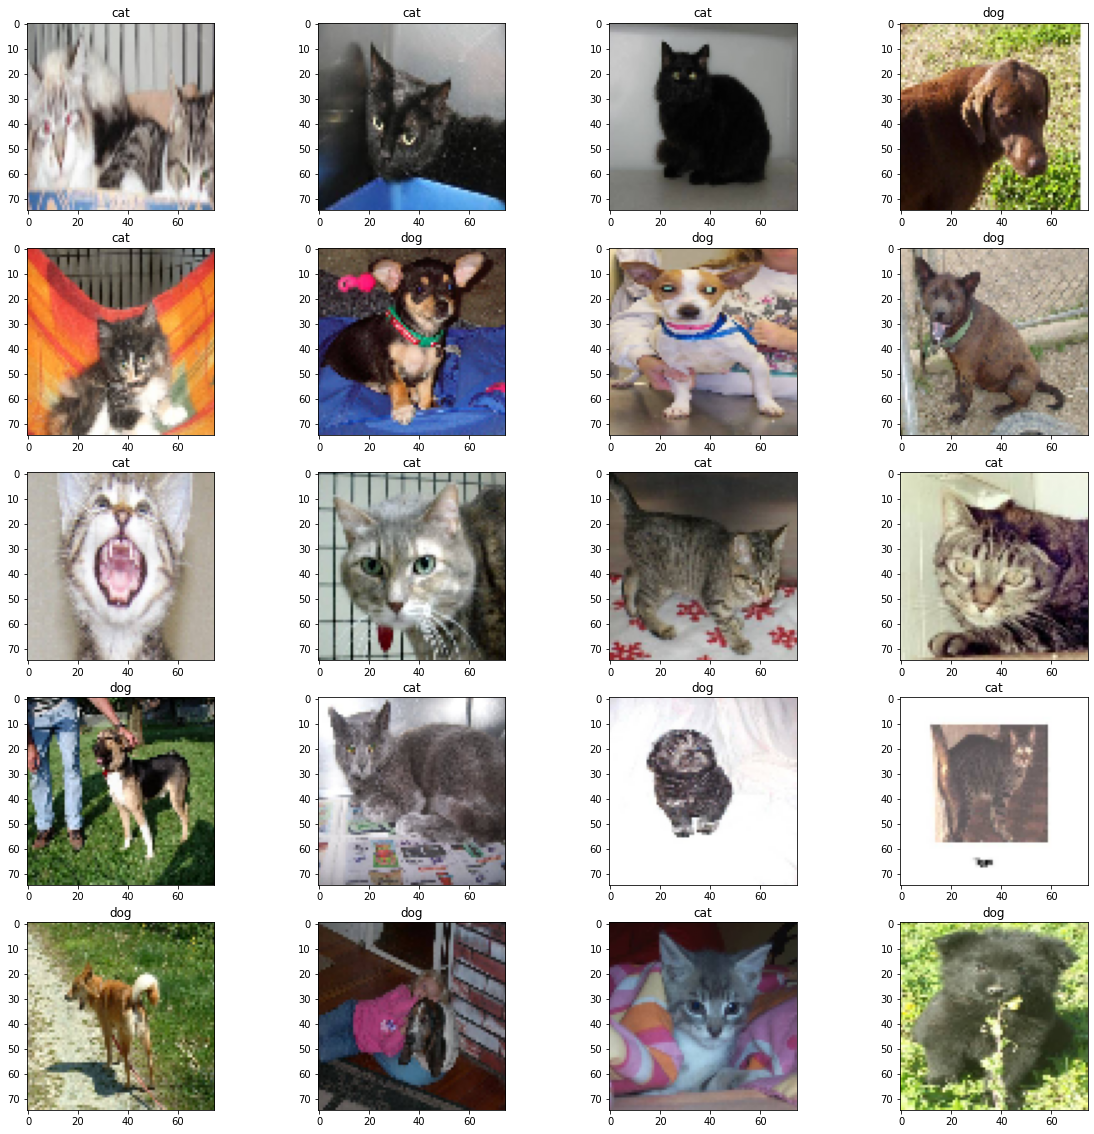

In [ ]:
#Show some training images with labels
count = 0;
Num_of_Images = 20;
plt.figure(figsize=(20,20))
for i in np.random.randint(1000, size = Num_of_Images):
  count = count+1;
  plt.subplot(Num_of_Images/4,4, count);
  plt.imshow(train_Data[i][0])
  P = train_Data[i][1];
  if(P[0]>P[1]):
      plt.title('cat')
  else:
      plt.title('dog');

In [ ]:
# Prepare the data for the training by separating X and Y vectors.
X_train = np.zeros((500,224,224,3));
Y_train = np.zeros((500,2));
for i in tqdm(range(0,500)):
  img = train_Data[i][0];
  X_train[i] = cv2.resize(img, (224,224));
  Y_train[i] = train_Data[i][1];

X_test = np.zeros((500,224,224,3));
Y_test = np.zeros((500,2));
for i in tqdm(range(0,500)):
  img = test_Data[i][0];
  X_test[i] = cv2.resize(img, (224,224));
  Y_test[i] = test_Data[i][1];

100%|██████████| 500/500 [00:00<00:00, 1787.30it/s]


In [ ]:
import tensorflow as tf;
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
# We build the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = Flatten()(last)
x = Dense(1000, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='softmax', name='predictions')(x)
model = Model(base_model.input, x)
# We compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Layer input_1 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
____________________

In [ ]:
# We start the training
epochs = 10
# We train it
model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Epoch 1/10
16/16 [==============================] - 4s 231ms/step - loss: 5.8338 - accuracy: 0.5440 - val_loss: 0.9576 - val_accuracy: 0.7720
Epoch 2/10
16/16 [==============================] - 3s 184ms/step - loss: 0.6875 - accuracy: 0.8320 - val_loss: 0.8666 - val_accuracy: 0.7840
Epoch 3/10
16/16 [==============================] - 3s 174ms/step - loss: 0.2341 - accuracy: 0.9060 - val_loss: 1.0390 - val_accuracy: 0.7460
Epoch 4/10
16/16 [==============================] - 3s 181ms/step - loss: 0.2414 - accuracy: 0.9040 - val_loss: 0.9384 - val_accuracy: 0.7400
Epoch 5/10
16/16 [==============================] - 3s 176ms/step - loss: 0.1261 - accuracy: 0.9500 - val_loss: 0.8835 - val_accuracy: 0.7720
Epoch 6/10
16/16 [==============================] - 3s 183ms/step - loss: 0.0720 - accuracy: 0.9700 - val_loss: 0.7580 - val_accuracy: 0.7780
Epoch 7/10
16/16 [==============================] - 3s 183ms/step - loss: 0.0255 - accuracy: 0.9860 - val_loss: 0.7463 - val_accuracy: 0.7780
Epoch 